# Investigating factors related to quality in Portuguese Wines

This dataset contains the results of 11 common physicochemical tests on a selection of 6,497 wines from Northwest Portugal. It was assembled with the goal of helping understand what factors impact quality in wine, something I'll also be looking into in this notebook.

URL: https://archive.ics.uci.edu/dataset/186/wine+quality

In [22]:
from ucimlrepo import fetch_ucirepo

Firstly let's retreive the data and take a look at it.

In [24]:
wine_quality_dataset = fetch_ucirepo(id=186) # This line may hang for a bit, it's a ~80mb data set

wine_quality_dataset.data.keys()


dict_keys(['ids', 'features', 'targets', 'original', 'headers'])

So we see that there are 5 parts to this data set.
- `ids` is a `None` value in this instance
- `features` is the physiochemical details minus the ratings
- `targets` is just the ratings on their own
- `original` is all of the data together
- `headers` is all of the header values for the `originals` data set

Now if we were training a model to predict quality then keeping out data seperated into `features` and `targets` would be useful. But since we're just exploring we're going to focus on the whole dataset, as stored in `original`.

In [25]:
wine_quality = wine_quality_dataset.data.original

wine_quality.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


As we see it contains a row id, 11 physiochemical test results, the rating, and the colour. For 14 columns total.

Let's take a look at some of those numbers now:

In [26]:
wine_quality.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


The first thing I notice is the counts, they all have the same count and it's the number we expect from the description of the dataset. This means no missing values. Secondly, I notice that the `color` header is gone-- as a catagorical variable it's not included in `describe`.

Let's check how many of each color we have.

In [27]:
colors = wine_quality.color

colors.value_counts()

color
white    4898
red      1599
Name: count, dtype: int64

So we see that there are roughly three time as many whites as reds in this dataset, and that the sum is what we expect.

There are some other things that jump out from that description, but it's hard to really understand just from summary statistics. So let's try some visualisations. 

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

Now that we have that let's take a look at that quality metric.

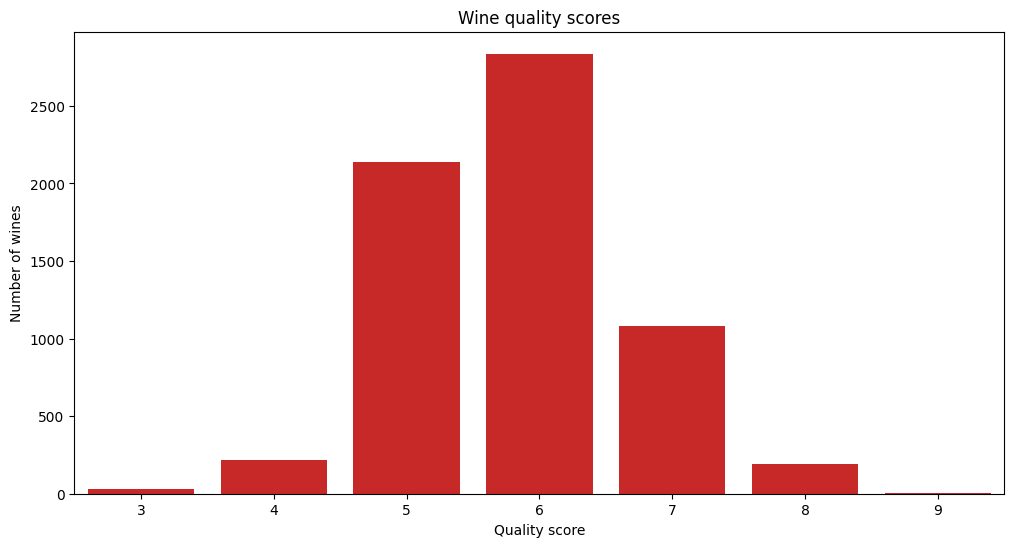

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

In [43]:
quality_counts = wine_quality["quality"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.countplot(data=wine_quality, x="quality", color="#e10e0e")
plt.title("Wine quality scores")
plt.xlabel("Quality score")
plt.ylabel("Number of wines")
plt.show()

quality_counts


So dispite being ostensibly a 1-10 scale, nothing gets above a 9 or below a 3. And the mean and median are both above the halfway point.

I'd like to dig into some of these feature in more details, but I'd rather not go though all of them. Let's take a look at which of the physiochemical features seems to correlate most with quality, and decided how to narrow things down.

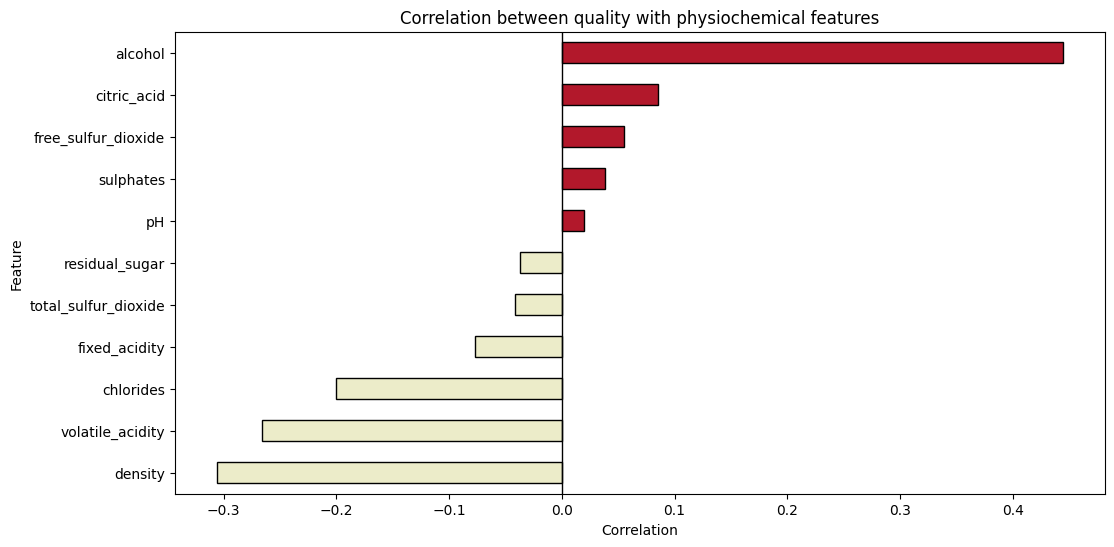

density                -0.305858
volatile_acidity       -0.265699
chlorides              -0.200666
fixed_acidity          -0.076743
total_sulfur_dioxide   -0.041385
residual_sugar         -0.036980
pH                      0.019506
sulphates               0.038485
free_sulfur_dioxide     0.055463
citric_acid             0.085532
alcohol                 0.444319
Name: quality, dtype: float64

In [ ]:
quality_correlations = (
    wine_quality.corr(numeric_only=True)["quality"]
    .drop(index="quality")
    .sort_values()
)

bar_colors = quality_correlations.apply(
    lambda value: "#ececc9" if value < 0 else "#b2182b"
)

plt.figure(figsize=(12, 6))
quality_correlations.plot(
    kind="barh", color=bar_colors, edgecolor="black"
)
plt.axvline(0, color="black", linewidth=1)
plt.title("Correlation between quality and physiochemical features")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

quality_correlations


Alcohol, Density, Volatile Acidity, and Chlorides seem to have the most effect, but let's also check the P values just to make sure.

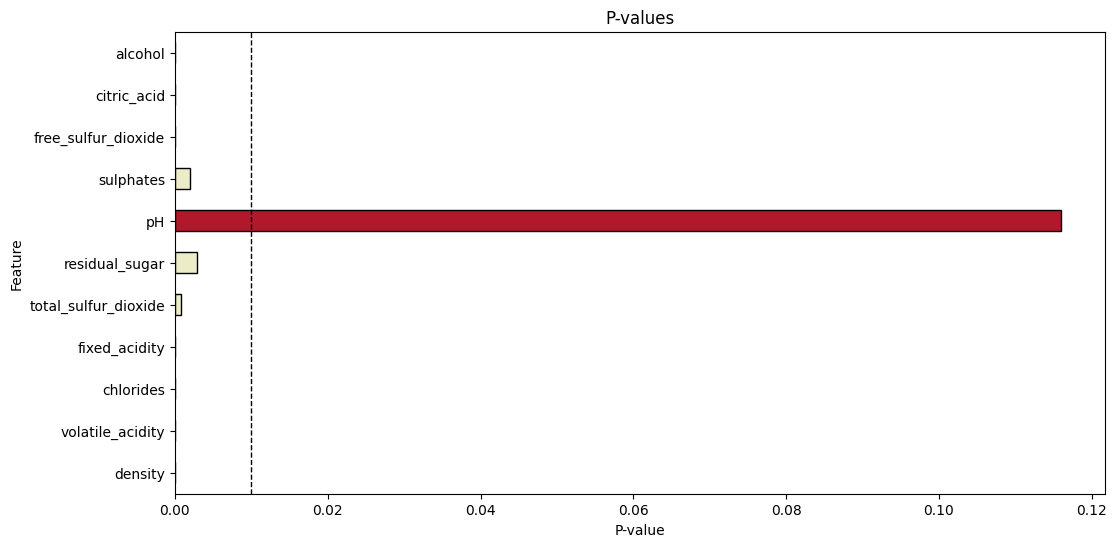

,correlation,p_value
density,-0.305858,9.662665e-141
volatile_acidity,-0.265699,2.061959e-105
chlorides,-0.200666,5.316452e-60
fixed_acidity,-0.076743,5.874849e-10
total_sulfur_dioxide,-0.041385,8.480397e-04
residual_sugar,-0.036980,2.871025e-03
pH,0.019506,1.159310e-01
sulphates,0.038485,1.918079e-03
free_sulfur_dioxide,0.055463,7.708445e-06
citric_acid,0.085532,5.001764e-12


In [90]:
pearson_correlations = []
quality_p_values = []
for feature in quality_correlations.index:
    correlation, p_value = stats.pearsonr(wine_quality[feature], wine_quality["quality"])
    pearson_correlations.append(correlation)
    quality_p_values.append(p_value)

quality_correlation_significance = pd.DataFrame(
    {
        "correlation": pearson_correlations,
        "p_value": pd.Series(quality_p_values, index=quality_correlations.index),
    }
)

threshhold = 0.01

plt.figure(figsize=(12, 6))
bar_colors = quality_correlation_significance["p_value"].apply(
    lambda value: "#ececc9" if value <= threshhold else "#b2182b"
)
quality_correlation_significance["p_value"].plot(
    kind="barh", color=bar_colors, edgecolor="black"
)
plt.axvline(threshhold, color="black", linestyle="--", linewidth=1)
plt.title("P-values")
plt.xlabel("P-value")
plt.ylabel("Feature")
plt.show()

quality_correlation_significance

As expected, with our reasonably large sample size almost all of our values are significant at our threshhold of 0.01, however we may still be able to eliminate some potential correlates by using Bonferroni correction

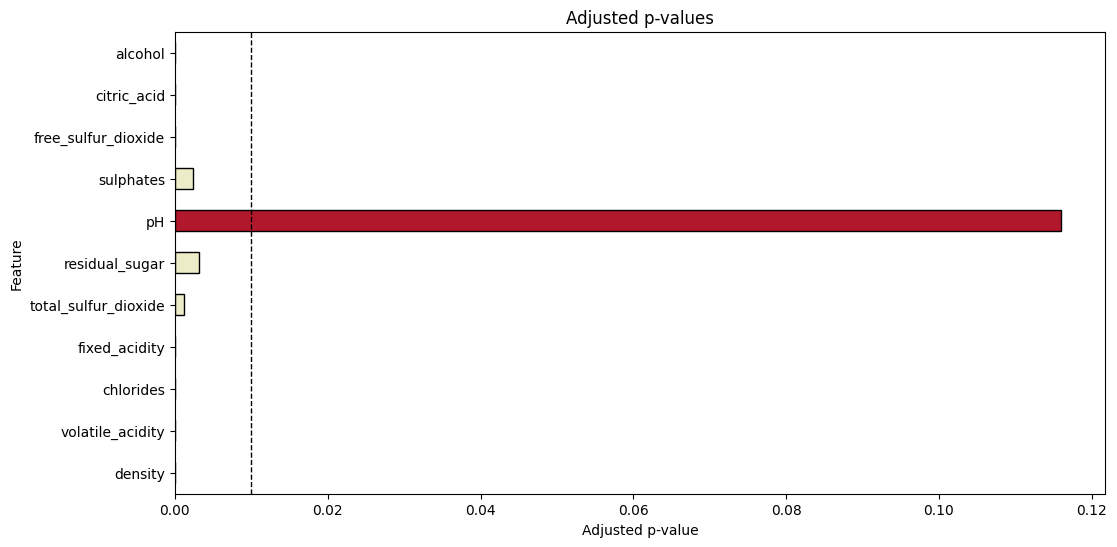

,correlation,p_value,p_value_adj
density,-0.305858,9.662665e-141,5.314466e-140
volatile_acidity,-0.265699,2.061959e-105,7.560515e-105
chlorides,-0.200666,5.316452e-60,1.462024e-59
fixed_acidity,-0.076743,5.874849e-10,1.077056e-09
total_sulfur_dioxide,-0.041385,8.480397e-04,1.166055e-03
residual_sugar,-0.036980,2.871025e-03,3.158127e-03
pH,0.019506,1.159310e-01,1.159310e-01
sulphates,0.038485,1.918079e-03,2.344318e-03
free_sulfur_dioxide,0.055463,7.708445e-06,1.211327e-05
citric_acid,0.085532,5.001764e-12,1.100388e-11


In [ ]:
quality_correlation_significance["p_value_adj"] = stats.false_discovery_control(
    quality_correlation_significance["p_value"], method="bh"
)


plt.figure(figsize=(12, 6))
bar_colors = quality_correlation_significance["p_value_adj"].apply(
    lambda value: "#ececc9" if value <= threshhold else "#b2182b"
)
quality_correlation_significance["p_value_adj"].plot(
    kind="barh", color=bar_colors, edgecolor="black"
)
plt.axvline(threshhold, color="black", linestyle="--", linewidth=1)
plt.title("Adjusted p-values")
plt.xlabel("Adjusted p-value")
plt.ylabel("Feature")
plt.show()

quality_correlation_significance
